In [267]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer, LabelEncoder, MaxAbsScaler, MinMaxScaler, OneHotEncoder, \
    OrdinalEncoder, RobustScaler, StandardScaler

# Exercise 2 - Debugging - Drugs

The dataset contains a set of patients, all of whom suffered from the same illness.
During their course of treatment, each patient responded to one of 5 medications: Drug A, Drug B, Drug c, Drug x or y.

This complex dataset proposes a set of challenges that you'll try to overcome. A basic ML pipeline is already in place. You have to optimize the performance of the model by applying good practices, debugging pre-processing errors, etc.

**Rules**:
- Do not use other modules than those already imported *(or do it only if your own code is not working. In this case, keep your own code in the notebook, commented, so that we know what you tried)*.
- Explain **all** of your choices. For every task, choose the most appropriate option for this problem and describe your choice.
- You can modify any parts of the code or replace the model by one already used in previous PWs.

**Work to do**:
- [x] Apply a type of normalization.
- [x] Encode categorical data.
- [x] Use all columns in the dataset (or choose the most meaningful features).
- [x] Choose a more appropriate metric.
- [x] Optimize hyper-parameters.
- [x] Test the model performance correctly using a separated test set.
- Apply **two** of those techniques:
  - [x] Keep relative class frequencies in the train/test sets (check train_test_split docs)
  - [ ] Show which feature(s) are the most correlated to the target.
  - [x] Use cross-validation.

In [268]:
df = pd.read_csv("drug.csv")
df.head()

,age,sex,bp,cholesterol,Na_to_K,drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [269]:
np.unique(df['cholesterol'])

array(['HIGH', 'NORMAL'], dtype=object)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          200 non-null    int64  
 1   sex          200 non-null    object 
 2   bp           200 non-null    object 
 3   cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [271]:
categorical_columns = ["sex", "bp", "cholesterol", "drug"]

# TODO: you will replace this by a more adapted preprocessing step
#df = df.drop(columns=["sex", "bp", "cholesterol"])

In [272]:
#X = df.drop(columns="drug")
#y = df["drug"]

In [273]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [274]:
# TODO: a preprocessing step is likely missing here...
# TODO: Apply a type of normalization
# Using StandardScaler to normalize 'age' and 'Na_to_K'
# StandardScaler is a good choice because it's robust to outliers and it's a good practice to normalize data when using KNN
scaler = StandardScaler()
df[['age', 'Na_to_K']] = scaler.fit_transform(df[['age', 'Na_to_K']]) # fit_transform() returns a numpy array, so we have to convert it back to a dataframe
# TODO: Encode categorical data
# Using LabelEncoder to encode 'bp'
# LabelEncoder is a good choice because it's a simple way to encode categorical data as integers (LOW, NORMAL, HIGH -> 0, 1, 2)
label_encoder = LabelEncoder()
df['bp'] = label_encoder.fit_transform(df['bp'])
# Using OneHotEncoder to encode 'sex' and 'cholesterol'
# OneHotEncoder is a good choice because it's a simple way to convert categorical data into a numerical format by creating binary columns for each category/label
encoder = OneHotEncoder(drop="first")  # Avoiding multicollinearity by dropping one category each
encoded_features = pd.DataFrame(encoder.fit_transform(df[['sex', 'cholesterol']]).toarray(),
                                columns=encoder.get_feature_names_out(['sex', 'cholesterol']))
df = pd.concat([df.drop(columns=['sex', 'cholesterol']), encoded_features], axis=1)

In [275]:
df

,age,bp,Na_to_K,drug,sex_M,cholesterol_NORMAL
0,-1.291591,0,1.286522,drugY,0.0,0.0
1,0.162699,1,-0.415145,drugC,1.0,0.0
2,0.162699,1,-0.828558,drugC,1.0,0.0
3,-0.988614,2,-1.149963,drugX,0.0,0.0
4,1.011034,1,0.271794,drugY,0.0,0.0
...,...,...,...,...,...,...
195,0.708057,1,-0.626917,drugC,0.0,0.0
196,-1.715759,1,-0.565995,drugC,1.0,0.0
197,0.465676,2,-0.859089,drugX,1.0,0.0
198,-1.291591,2,-0.286500,drugX,1.0,1.0


In [276]:
X = df.drop(columns="drug")
y = df["drug"]

In [277]:
X

,age,bp,Na_to_K,sex_M,cholesterol_NORMAL
0,-1.291591,0,1.286522,0.0,0.0
1,0.162699,1,-0.415145,1.0,0.0
2,0.162699,1,-0.828558,1.0,0.0
3,-0.988614,2,-1.149963,0.0,0.0
4,1.011034,1,0.271794,0.0,0.0
...,...,...,...,...,...
195,0.708057,1,-0.626917,0.0,0.0
196,-1.715759,1,-0.565995,1.0,0.0
197,0.465676,2,-0.859089,1.0,0.0
198,-1.291591,2,-0.286500,1.0,1.0


In [278]:
# Splitting the dataset and ensuring relative class frequencies using the 'stratify' parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [279]:
def predict(estimator, X, y, show_cm=True):
    # predict (change knn by estimator)
    y_pred = estimator.predict(X)
    
    # show confusion matrix
    if show_cm:
        cm = confusion_matrix(y, y_pred)
        disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
        disp.plot()
    
    # check metric (this one is probably not the best choice...)
    metric = metrics.accuracy_score(y, y_pred)
    f1 = metrics.f1_score(y, y_pred, average='weighted')
    #print(f"Accuracy: {metric}")
    #print(f"Recall: {f1}")
    return metric, f1
    # f1 metric is better than others because it takes into account both precision and recall

# Find the best hyper-parameters (n_neighbours) and print the test set best value

The best knn paramters is n = 5 and the best accuracy achieved is 0.9
The best accuracy for the Test Set is 0.9 and the f1_score is 0.90254329004329


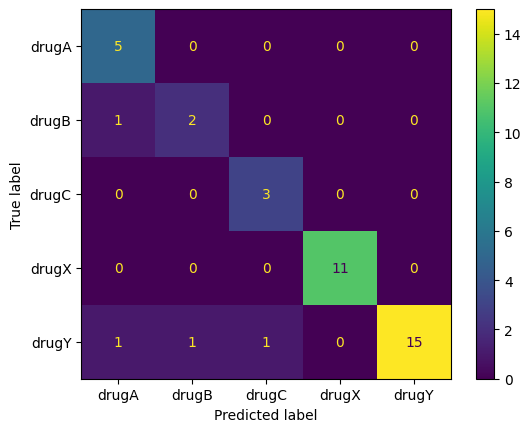

In [280]:
best_neigh_simple = None 
best_accur_simple = 0.0
best_f1_score = 0.0
for i in range(30): 
    knn = KNeighborsClassifier(n_neighbors=i+1)
    knn.fit(X_train, y_train)
    precision, f1_score = predict(knn, X_test, y_test, show_cm=False)
    #print(precision, i+1)
    if precision > best_accur_simple: 
        best_neigh_simple = i+1
        best_accur_simple = precision
        #print(f"New best accuracy : {best_accur_simple} + {best_neigh_simple}")
        
print(f"The best knn paramters is n = {best_neigh_simple} and the best accuracy achieved is {best_accur_simple}")

knn = KNeighborsClassifier(n_neighbors=best_neigh_simple) 
knn.fit(X_train,y_train) 
precision_test, f1_score_test = predict(knn, X_test, y_test) 
print(f"The best accuracy for the Test Set is {precision_test} and the f1_score is {f1_score_test}")

(0.9, 0.8991666666666667)

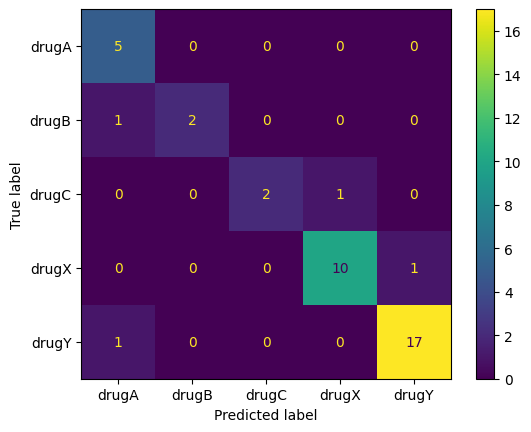

In [281]:
# Evaluating the model on the test set
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
predict(knn, X_test, y_test)

# Do the cross validation with the function cross_val_score (find the best k + print the test set with that result)

New best accuracy : 0.89375 + 1
The best knn paramters is n = 1 and the best accuracy achieved with cross_validation is 0.89375


(0.85, 0.8541625041625043)

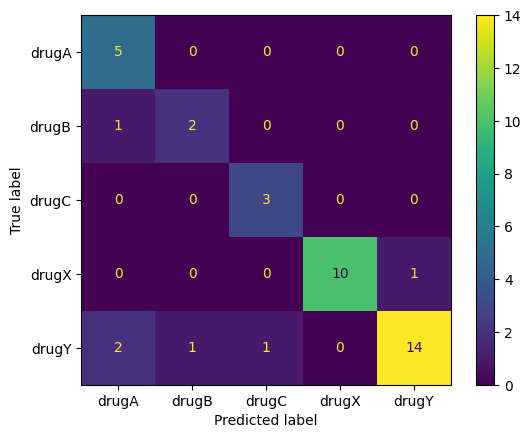

In [282]:
# TODO: any of the 3 proposed task...
# source: https://www.ritchieng.com/machine-learning-cross-validation/

best_neigh = None 
best_accur = 0.0
for i in range(50): # no need to go further than 50 neighbors because the accuracy is already decreasing after 30 neighbors
    knn = KNeighborsClassifier(n_neighbors=i+1) # '0' as neighbors is not allowed
    cross = model_selection.cross_val_score(knn, X_train, y_train) # call the function that does the cross validation (it does the fit() and accuracy of the 5 folds by itself)
    if np.mean(cross) > best_accur: # keep the best neighbors and accuracy (mean of the 5 folds)
        best_neigh = i+1
        best_accur = np.mean(cross)
        print(f"New best accuracy : {best_accur} + {best_neigh}")
        
print(f"The best knn paramters is n = {best_neigh} and the best accuracy achieved with cross_validation is {best_accur}")

knn = KNeighborsClassifier(n_neighbors=best_neigh) # Keep the best neighbors found before to make our prediction on the test set
knn.fit(X_train,y_train) # On fit
predictions = predict(knn, X_test, y_test) # predict on the test set
predictions # print the precision and f1_score
